In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#initiate device (CPU or GPU)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    devuce = 'cpu'

# Preprocess MNIST Data

In [3]:
#apply preprocessing transformations of Normalizing and converting datatype to pytorch tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

#load in MNIST train and test dataset
train_dataset = torchvision.datasets.MNIST('data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST('data', train=True, transform=transform, download=True)

In [4]:
#convert dataset to pytorch dataloader object to iterate through batches
batch_size = 124

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

In [5]:
images_sample, labels_sample = next(iter(train_loader))
print('Format of MNIST images: ',images_sample.size(), ' = format([Batch Size, Color dim, Width, Height])\n')
print('STEP 1: Squish the incoming batch of images to a 1D Tensor with size of first input layer:') 
print(images_sample[2].size(), ' -----> ', images_sample[2].view(images_sample[2].size(0), -1).size())
print('\nNOTE, the squished Tensor is still a 2D tensor but the x dimension is only of length 1, making it')
print('essentially a 1D tensor in the Y-Axis\n')
print('STEP 2: Feed batch of images through the MLP\n')
print('STEP 3: Train the model\n')
print('STEP 4: Test the model\'s accuracy')

Format of MNIST images:  torch.Size([124, 1, 28, 28])  = format([Batch Size, Color dim, Width, Height])

STEP 1: Squish the incoming batch of images to a 1D Tensor with size of first input layer:
torch.Size([1, 28, 28])  ----->  torch.Size([1, 784])

NOTE, the squished Tensor is still a 2D tensor but the x dimension is only of length 1, making it
essentially a 1D tensor in the Y-Axis

STEP 2: Feed batch of images through the MLP

STEP 3: Train the model

STEP 4: Test the model's accuracy


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Corresponding respective labels:  [5, 5, 0, 6, 5, 9]


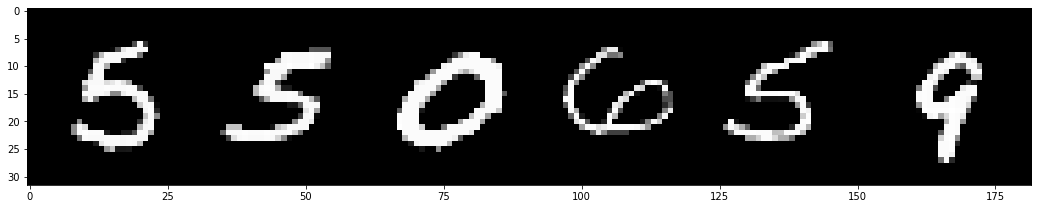

In [7]:
grid_img = torchvision.utils.make_grid(images_sample[:6], nrow=6)
fig, ax = plt.subplots(figsize=(18, 4))
ax.imshow(grid_img.permute(1, 2, 0))
print('Corresponding respective labels: ', labels_sample[:6].tolist())

# Define Multi-Layer Perceptron

In [8]:
#option to choose activation function between relu and tanh (default: relu)
def choose_activation(string):
    if string == 'relu':
        return nn.ReLU()
    elif string == 'tanh':
        return nn.Tanh()

#MLP Model
class Classifier(nn.Module):
    def __init__(self, activation_func='relu'):
        super(Classifier, self).__init__()
        self.activation_func = choose_activation(activation_func)
        self.mlp = nn.Sequential(
            #MNIST Input shape of each MNIST image is [1, 28, 28]
            nn.Dropout(0.4),
            nn.Linear(1*28*28, 500),
            self.activation_func,
            nn.BatchNorm1d(500),     #apply batch norm to improve training

            nn.Dropout(0.4),
            nn.Linear(500, 200),
            self.activation_func,
            nn.BatchNorm1d(200),

            nn.Linear(200, 10), 
            nn.Sigmoid()    #squish between 0 and 1. 0 being not classified and 1 being classified
        )
    def forward(self, input):
        #squish 3D tensor of image to "1D"
        input = input.view(input.size(0), -1)
        input = self.mlp(input) # pass through MLP
        return input 

# Train the model

In [9]:
mlp = Classifier().to(device) #default relu
loss_func = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(mlp.parameters(), lr = 0.001)

In [12]:
epochs = 100

if device == 'cuda:0':
    print('----> Using GPU\n')
else:
    print('----> Using CPU\n')

min_loss = np.Inf

for epoch in range(epochs):
    train_loss = 0  #keep track of training loss each way
    for images, labels in train_loader:
        mlp.zero_grad() #zero out gradients for training

        outputs = mlp(images.to(device))
        loss = loss_func(outputs, labels.to(device))    #measure loss
        loss.backward()   #compute differential loss dloss/dx
        optimizer.step()    #gradient descent
        train_loss += loss.item()/len(images)

    print('Epoch: {}, Train Loss: {:.4f}\n'.format(   #print training loss at each step
        epoch,
        train_loss
    )) 
    if train_loss < min_loss:   #print lowest loss
        print('     New minimum loss {:.4f} ---> {:.4f}\n'.format(
            min_loss,
            train_loss
        ))

        min_loss = train_loss
        torch.save(mlp.state_dict(), 'best_model.pt')   #save model to file

----> Using GPU

Epoch: 0, Train Loss: 5.8971

     New minimum loss inf ---> 5.8971

Epoch: 1, Train Loss: 5.8935

     New minimum loss 5.8971 ---> 5.8935

Epoch: 2, Train Loss: 5.8889

     New minimum loss 5.8935 ---> 5.8889

Epoch: 3, Train Loss: 5.8883

     New minimum loss 5.8889 ---> 5.8883

Epoch: 4, Train Loss: 5.8841

     New minimum loss 5.8883 ---> 5.8841

Epoch: 5, Train Loss: 5.8792

     New minimum loss 5.8841 ---> 5.8792

Epoch: 6, Train Loss: 5.8803

Epoch: 7, Train Loss: 5.8761

     New minimum loss 5.8792 ---> 5.8761

Epoch: 8, Train Loss: 5.8733

     New minimum loss 5.8761 ---> 5.8733

Epoch: 9, Train Loss: 5.8735

Epoch: 10, Train Loss: 5.8683

     New minimum loss 5.8733 ---> 5.8683

Epoch: 11, Train Loss: 5.8701

Epoch: 12, Train Loss: 5.8692

Epoch: 13, Train Loss: 5.8633

     New minimum loss 5.8683 ---> 5.8633

Epoch: 14, Train Loss: 5.8622

     New minimum loss 5.8633 ---> 5.8622

Epoch: 15, Train Loss: 5.8638

Epoch: 16, Train Loss: 5.8623

Epoch: 

# Load and Test Model

In [18]:
model = Classifier().to(device)
model.load_state_dict(torch.load('best_model.pt'))    #load model
print('Model Loaded: ')
print(model)

Model Loaded: 
Classifier(
  (activation_func): ReLU()
  (mlp): Sequential(
    (0): Dropout(p=0.4, inplace=False)
    (1): Linear(in_features=784, out_features=500, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.4, inplace=False)
    (5): Linear(in_features=500, out_features=200, bias=True)
    (6): ReLU()
    (7): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=200, out_features=10, bias=True)
    (9): Sigmoid()
  )
)


In [19]:
#make array of 0 with length of the # of unique labels
#each index will correspond to the score of that given index number (0-9) in mnist dataset
right = np.zeros((10), dtype=int)   
wrong = np.zeros((10), dtype=int)

for images, labels in test_loader:
    outputs = model(images.to(device))

    for i in range(len(images)):
        if(torch.argmax(outputs[i]) == labels[i]).tolist(): #check if classification is equal to corresponding label
            right[labels[i]] += 1
        else:
            wrong[labels[i]] += 1
    
for i in range(len(right)):
    print('Accuracy of {}: {:.4f}'.format(
        i,
        right[i]/(right[i] + wrong[i])
    ))
print('Mean Accuracy of model: {:.4f}'.format(
    sum(right)/(sum(right) + sum(wrong))
))

Accuracy of 0: 0.9846
Accuracy of 1: 0.9786
Accuracy of 2: 0.9649
Accuracy of 3: 0.9444
Accuracy of 4: 0.9570
Accuracy of 5: 0.9585
Accuracy of 6: 0.9750
Accuracy of 7: 0.9617
Accuracy of 8: 0.9595
Accuracy of 9: 0.9496
Mean Accuracy of model: 0.9636


# Visualizing Prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Corresponding Classification Results:  [[2], [1], [2], [9], [7], [0]]


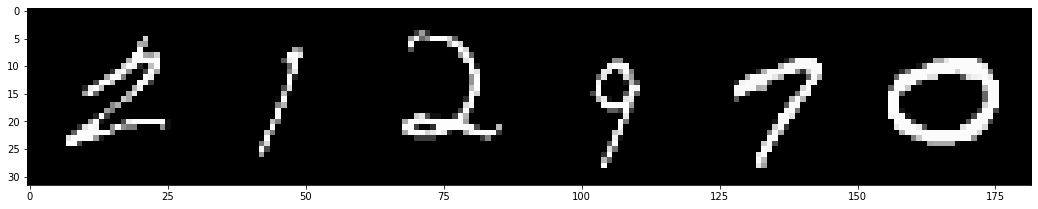

In [20]:
images, labels = next(iter(test_loader))
output_test = model(images.to('cuda'))
output_list = []
for i in range(6):
    output_list.append([torch.argmax(output_test[i]).tolist()])
gri_img = torchvision.utils.make_grid(images[:6], nrow=6)
fig, axi = plt.subplots(figsize=(18, 4))
axi.imshow(gri_img.permute(1, 2, 0))
print('Corresponding Classification Results: ', output_list)